In [1]:
import contextvars
import time
from typing import Any, Optional, Dict, List, Union
from dataclasses import dataclass, field

In [2]:
# 定义两个上下文变量，存储当前 Span 和 Trace
_current_span: contextvars.ContextVar[Optional["Span"]] = contextvars.ContextVar(
    "current_span", default=None
)

_current_trace: contextvars.ContextVar[Optional["Trace"]] = contextvars.ContextVar(
    "current_trace", default=None
)

In [3]:
@dataclass
class SpanContext:
    """Span 的上下文信息（用于跨进程传递）"""
    trace_id: str
    span_id: str
    is_remote: bool = False

In [4]:
@dataclass
class Span:
    """表示一个操作的时间段追踪"""
    name: str
    context: SpanContext
    parent: Optional["Span"] = None
    start_time: float = field(default_factory=time.time)
    end_time: Optional[float] = None
    attributes: Dict[str, Any] = field(default_factory=dict)
    events: List[Dict[str, Any]] = field(default_factory=list)
    status: str = "UNSET"

    def end(self, status: str = "OK") -> None:
        """结束 Span 并记录状态"""
        self.end_time = time.time()
        self.status = status

    def add_event(self, name: str, attributes: Optional[Dict[str, Any]] = None) -> None:
        """添加事件到 Span"""
        self.events.append({
            "name": name,
            "timestamp": time.time(),
            "attributes": attributes or {}
        })

    def __enter__(self) -> "Span":
        """支持 with 语句"""
        return self

    def __exit__(self, exc_type, exc_val, exc_tb) -> None:
        """自动结束 Span"""
        self.end("ERROR" if exc_type else "OK")

In [5]:
@dataclass
class Trace:
    """完整的追踪链"""
    root_span: Span
    spans: List[Span] = field(default_factory=list)

    def add_span(self, span: Span) -> None:
        """添加 Span 到 Trace"""
        self.spans.append(span)

In [6]:
def generate_id() -> str:
    """生成追踪ID（简化版）"""
    return f"id-{int(time.time() * 1000)}"

def get_current_span() -> Optional[Span]:
    """获取当前 Span"""
    return _current_span.get()

def get_current_trace() -> Optional[Trace]:
    """获取当前 Trace"""
    return _current_trace.get()

In [7]:
def start_span(name: str, attributes: Optional[Dict[str, Any]] = None) -> Span:
    """
    创建并激活一个新 Span
    :param name: Span 名称
    :param attributes: 附加属性
    :return: 新创建的 Span
    """
    parent = get_current_span()
    context = SpanContext(
        trace_id=parent.context.trace_id if parent else generate_id(),
        span_id=generate_id()
    )

    span = Span(name=name, context=context, parent=parent)
    if attributes:
        span.attributes.update(attributes)

    # 设置当前 Span
    _current_span.set(span)

    # 如果是根 Span，则创建 Trace
    if parent is None:
        trace = Trace(root_span=span)
        _current_trace.set(trace)
    else:
        trace = get_current_trace()
    
    if trace:
        trace.add_span(span)

    return span

def end_span(status: str = "OK") -> None:
    """结束当前 Span 并返回父 Span"""
    current = get_current_span()
    if current:
        current.end(status)
        _current_span.set(current.parent)

In [8]:
class ConsoleExporter:
    """将追踪数据打印到控制台"""
    @staticmethod
    def export(trace: Trace) -> None:
        print("\n=== Exporting Trace ===")
        print(f"Trace ID: {trace.root_span.context.trace_id}")
        for span in trace.spans:
            duration = (span.end_time or time.time()) - span.start_time
            print(f"Span: {span.name} ({duration:.3f}s), Status: {span.status}")

In [9]:
# 示例 1: 同步代码
with start_span("main_operation", {"type": "sync"}):
    # 当前 Span 是 "main_operation"
    with start_span("child_operation"):
        # 当前 Span 是 "child_operation"
        get_current_span().add_event("processing_start")
        time.sleep(0.1)
        get_current_span().add_event("processing_end")
    
    # 手动创建 Span
    span = start_span("manual_span")
    time.sleep(0.05)
    span.end()

# 导出追踪数据
if trace := get_current_trace():
    ConsoleExporter.export(trace)


=== Exporting Trace ===
Trace ID: id-1751644229941
Span: main_operation (0.151s), Status: OK
Span: child_operation (0.101s), Status: OK
Span: manual_span (0.051s), Status: OK


In [10]:
import asyncio

async def async_task():
    with start_span("async_operation"):
        print(f"Current span: {get_current_span().name}")
        await asyncio.sleep(0.1)

async def main():
    tasks = [async_task() for _ in range(3)]
    await asyncio.gather(*tasks)

await main()

Current span: async_operation
Current span: async_operation
Current span: async_operation


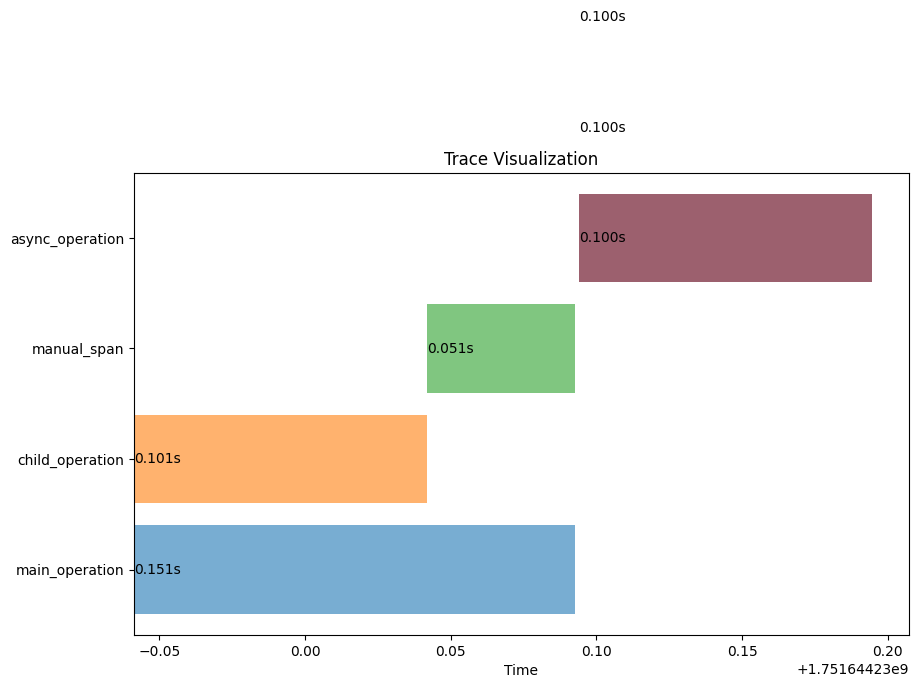

In [11]:
import matplotlib.pyplot as plt

def visualize_trace(trace: Trace):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, span in enumerate(trace.spans):
        duration = (span.end_time or time.time()) - span.start_time
        ax.barh(span.name, duration, left=span.start_time, alpha=0.6)
        ax.text(span.start_time, i, f"{duration:.3f}s", va='center')
    
    ax.set_xlabel('Time')
    ax.set_title('Trace Visualization')
    plt.show()

if trace := get_current_trace():
    visualize_trace(trace)